In [1]:
import Tasks2
from Tasks2 import final_data
import re
# # Cash me outside how bow dah
# import requests
# import requests_cache
# requests_cache.install_cache("cache")

In [2]:
# # Extract song info from html
# from bs4 import BeautifulSoup
# billboard_url = "http://www.billboard.com/articles/list/2155531/the-hot-100-all-time-top-songs"
# soup = BeautifulSoup((requests.get(billboard_url)).text, "html.parser")
# songs = [song.text for song in soup.find_all("h3", {"class": "list-data__title"})]

In [3]:
# # Extra title, artist, and year info
# import re
# # We consider only the first year for a song if more than one: the 100th song's case
# titles  = [str(re.sub(r"\xe2\x80\xa6", r"...", re.sub("\"", "", re.match(r"\"[\"\']?.+\"[\"\']?", song).group(0)))) for song in songs]
# artists = [str(re.sub("^\"|\r|(- )|(.*\".*\" )","", re.search("\" .*\r", song).group(0)).lstrip()) for song in songs]
# years   = [int(re.sub("\)|\(|,", "", re.search("(\(\d{4}\))|(\(\d{4},)", song).group(0))) for song in songs]

In [4]:
# import pandas as pd 
# top100songs = pd.DataFrame({'Title': titles, 'Artist': artists, 'Year': years})

In [5]:
# top100songs.loc[53]

In [6]:
# import string

# def processString(s, type):
#     s = re.sub("['?:!.,;&/]+", " ", s).lower().strip()
#     if(type != "Artist"):
#         s = re.sub("-", "",s)
#     s = re.sub("\s+", "-", s)
#     return(s)

# def getLyrics(song, newUrl = ''):
#     artist = song['Artist']
#     title = song['Title']
#     #Remove punctuation and change to lower case.
#     artist = processString(artist, "Artist")
#     title = processString(title," Title")
#     lyric_url = "http://www.songlyrics.com/"+artist+"/"+title+"-lyrics/"
#     if newUrl != '':
#         lyric_url = newUrl
# #    print(lyric_url)
#     soup = BeautifulSoup((requests.get(lyric_url)).text, "html.parser")
#     tmp = soup.find_all('p', {"id": "songLyricsDiv"})
#     lyrics = tmp[0].get_text().encode("ascii","ignore")
#     if 'Sorry, we have no' in lyrics:
#         lyrics = ""
#     return({'Url':lyric_url, 'Lyric': lyrics})


In [7]:
# result = [getLyrics(row) for idx, row in top100songs.iterrows()]

In [8]:
#Couldn't Find
# Elton John - Candle in the wind 1997 something about the way you look tonight Lyrics
# paul-mccartney-and-michael-jackson/say-say-say-lyrics/
# jewel/you-were-meant-for-me-foolish-games-lyrics/

# weird ones: 53, 83, 60

In [9]:
# notFoundUrls = ["http://www.songlyrics.com/elton-john-billy-joel/candle-in-the-wind-lyrics/", "http://www.songlyrics.com/jewel-feat-kelly-clarkson/foolish-games-lyrics/"]
# result[53]['Lyric'] = getLyrics(top100songs.loc[53], newUrl = notFoundUrls[0])["Lyric"].encode("ascii","ignore")
# result[83]["Lyric"] = getLyrics(top100songs.loc[83], newUrl = notFoundUrls[1])["Lyric"].encode("ascii","ignore")

In [10]:
# song = top100songs.loc[60]
# artist = song['Artist']
# title = song['Title']
# lyric_url = "http://www.metrolyrics.com/say-say-say-lyrics-paul-mccartney.html"
# artist = processString(artist, "Artist")
# title = processString(title," Title")
# soup = BeautifulSoup((requests.get(lyric_url)).text, "html.parser")
# tmp = soup.find_all('div', {"id": "lyrics-body-text"})
# lyrics = tmp[0].get_text().encode("ascii","ignore")

# result[60]['Lyric'] = lyrics

In [11]:
# result_df = pd.DataFrame(result)
# main_df = pd.concat([top100songs,result_df], axis = 1)
# main_df["Rank"] = range(100, 0, -1)
# del main_df["Url"]

<h1>NGRAM DOOM HELLO NGRAM THERE ONCE WAS</h1>

In [12]:
import nltk 
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import WhitespaceTokenizer
from collections import Counter

In [13]:
# Making Corpus
corpus_raw = " ".join(final_data["Lyric"])
corpus_raw = re.sub(",", "", corpus_raw)
corpus_raw = re.sub("\n", " ", corpus_raw)
corpus_raw = re.sub("\\\\", "", corpus_raw).lower()
corpus_raw = re.sub("[)(]", "", corpus_raw)
corpus_raw_split = corpus_raw_split = corpus_raw.split(" ")

In [14]:
# Trigram for corpus
corpus_trigram = Counter(ngrams(corpus_raw_split, 3)).most_common()
corpus_trigram_keys = [" ".join(key_tuple) for key_tuple in [key[0] for key in corpus_trigram]]
corpus_trigram_values = [item[1] for item in corpus_trigram]
corpus_trigram = {"trigram": corpus_trigram_keys, "freq": corpus_trigram_values}

In [15]:
# Bigram for corpus
corpus_bigram = Counter(ngrams(corpus_raw_split, 2)).most_common()
corpus_bigram_keys = [" ".join(key_tuple) for key_tuple in [key[0] for key in corpus_bigram]]
corpus_bigram_values = [item[1] for item in corpus_bigram]
corpus_bigram = {"bigram": corpus_bigram_keys, "freq": corpus_bigram_values}

In [16]:
# Make list of words for a list of songs
song_lyrics_list = [re.sub("[)(]", "", lyric) for lyric in [re.sub("\\\\", "", lyric).lower() for lyric in [re.sub("\n", " ", lyric) for lyric in [re.sub(",", "", lyric) for lyric in list(final_data["Lyric"])]]]]
song_words_list = [[word for word in word_list if word != ''] for word_list in  [x.split(" ") for x in song_lyrics_list]]

In [17]:
# List of bi/trigrams for a list of songs
# Formatted as list of counters
song_bigram = [Counter(ngrams(song_lyrics, 2)) for song_lyrics in song_words_list]
song_trigram = [Counter(ngrams(song_lyrics, 3)) for song_lyrics in song_words_list]

In [18]:
# Formatted to list of dictionaries
song_bigram = [{"bigram": [" ".join(key_tuple) for key_tuple in bigram.keys()], "freq": bigram.values()} for bigram in song_bigram]
song_trigram = [{"trigram": [" ".join(key_tuple) for key_tuple in trigram.keys()], "freq": trigram.values()} for trigram in song_trigram]


In [19]:
corpus_trigram["trigram"]

[u'na na na',
 u'yeah yeah yeah',
 u'low low low',
 u'oh oh oh',
 u'you make me',
 u'boom boom boom',
 u'bites the dust',
 u'i love you',
 u'you and me',
 u'another one bites',
 u'one bites the',
 u'ooh ooh ooh',
 u"tonight's gonna be",
 u'be a good',
 u'gonna be a',
 u"let's get it",
 u"that tonight's gonna",
 u'round and round',
 u'what you do',
 u'all night all',
 u'how do i',
 u'night all night',
 u'tu cuerpo alegria',
 u'dale a tu',
 u'a tu cuerpo',
 u'cuerpo alegria macarena',
 u'i saw the',
 u'the boy is',
 u'boy is mine',
 u'your body talk',
 u'whoomp there it',
 u"i know you're",
 u'there it went',
 u'saw the sign',
 u'for me ',
 u'na na na-na-na-naa',
 u'all night long',
 u'moves like jagger',
 u"you're still the",
 u'still the one',
 u'killing me softly',
 u'with his song',
 u'me softly with',
 u"rock n' roll",
 u'softly with his',
 u'and round and',
 u'we found love',
 u'a good night',
 u'love in a',
 u'she hit the',
 u'let me hear',
 u"night that tonight's",
 u'in the deep

In [20]:
# Check for unique bigrams. A 0 means error, 1 means it is unique to a song, >1 means non-unique
# Errors caused by regex escape patterns in certain strings
#[sum([any([re.search("\\b" + cbigram + "\\b", bigram) for bigram in song["bigram"]]) for song in song_bigram]) for cbigram in corpus_bigram["bigram"]]

In [21]:
bigram_in_song = [sum([cbigram in song["bigram"] for song in song_bigram ]) for cbigram in corpus_bigram["bigram"]]
non_unique_bigram_indices_songs = [(bigram > 1,bigram) for bigram in bigram_in_song]
trigram_in_song = [sum([ctrigram in song["trigram"] for song in song_trigram ]) for ctrigram in corpus_trigram["trigram"]]
non_unique_trigram_indices_songs = [(trigram > 1,trigram) for trigram in trigram_in_song]

In [22]:
from itertools import compress
non_unique_bigrams = list(compress(corpus_bigram["bigram"], [x[0] for x in non_unique_bigram_indices_songs]))
non_unique_trigrams = list(compress(corpus_trigram["trigram"], [x[0] for x in non_unique_trigram_indices_songs]))
nu_bigram_freq = list(compress(corpus_bigram["freq"], [x[0] for x in non_unique_bigram_indices_songs]))
nu_trigram_freq = list(compress(corpus_trigram["freq"], [x[0] for x in non_unique_trigram_indices_songs]))
songs_per_bigram = [y[1] for y in non_unique_bigram_indices_songs if y[0]]
songs_per_trigram = [y[1] for y in non_unique_trigram_indices_songs if y[0]]
shared_bigrams = {"bigram": non_unique_bigrams, "freq": nu_bigram_freq, "songs": songs_per_bigram}
shared_trigrams = {"trigram": non_unique_trigrams, "freq": nu_trigram_freq, "songs": songs_per_trigram}

In [34]:
import pandas as pd
# Frequency 
# The dictionaries "shared_bigrams" and "shared_trigrams" contain
# the bigram, the number of times occurred, and the number of songs occured in
# pd.DataFrame(shared_bigrams).sort_values(by="songs", ascending = False)
tri_by_songs = pd.DataFrame(shared_trigrams).sort_values(by="songs", ascending = False)
tri_by_freq  = pd.DataFrame(shared_trigrams).sort_values(by="freq", ascending = False)
bi_by_songs = pd.DataFrame(shared_bigrams).sort_values(by="songs", ascending = False)
bi_by_freq  = pd.DataFrame(shared_bigrams).sort_values(by="freq", ascending = False)

In [27]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt

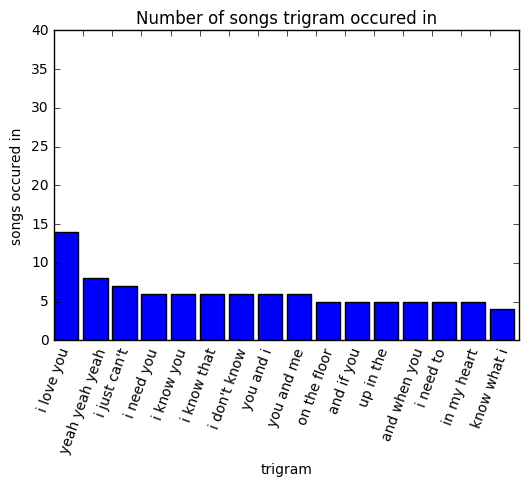

In [78]:
tri_by_song_y = list(tri_by_songs["songs"])[0:16]
plt.bar(range(16), tri_by_song_y, 1/1.2, color = "blue")
plt.xticks(range(16), list(tri_by_songs["trigram"])[0:16])
plt.xticks(rotation = 70)
plt.ylim([0,40])
plt.xlabel("trigram")
plt.ylabel("songs occured in")
plt.title("Number of songs trigram occured in")
plt.savefig('try_by_song.png')
plt.show()


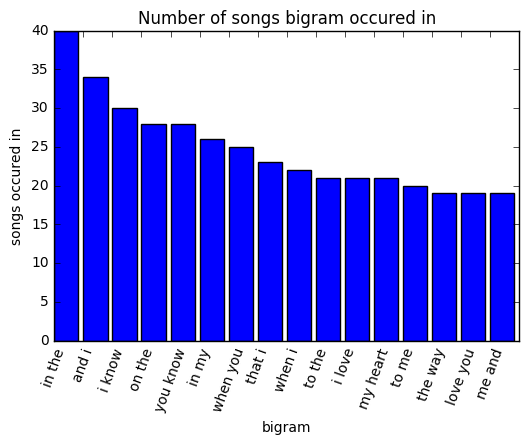

In [79]:
bi_by_song_y = list(bi_by_songs["songs"])[0:16]
plt.bar(range(16), bi_by_song_y, 1/1.2, color = "blue")
plt.xticks(range(16), list(bi_by_songs["bigram"])[0:16])
plt.xticks(rotation = 70)
plt.ylim([0,40])
plt.xlabel("bigram")
plt.ylabel("songs occured in")
plt.title("Number of songs bigram occured in")
plt.savefig('bi_by_song.png')
plt.show()


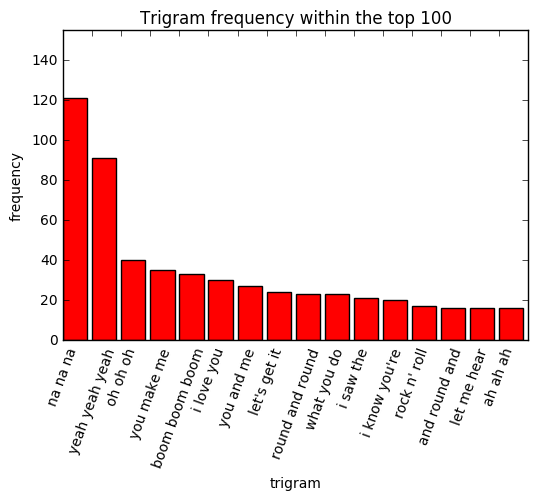

In [80]:
tri_by_freq_y = list(tri_by_freq["freq"])[0:16]
plt.bar(range(16), tri_by_freq_y, 1/1.2, color = "red")
plt.xticks(range(16), list(tri_by_freq["trigram"])[0:16])
plt.xticks(rotation = 70)
plt.ylim([0,155])
plt.xlabel("trigram")
plt.ylabel("frequency")
plt.title("Trigram frequency within the top 100")
plt.savefig('tri_by_freq.png')
plt.show()

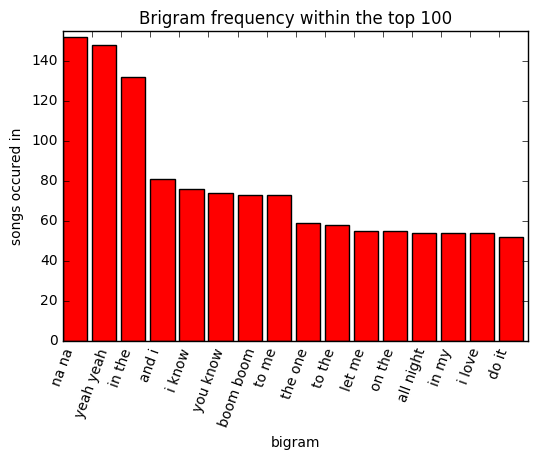

In [81]:
bi_by_freq_y = list(bi_by_freq["freq"])[0:16]
plt.bar(range(16), bi_by_freq_y, 1/1.2, color = "red")
plt.xticks(range(16), list(bi_by_freq["bigram"])[0:16])
plt.xticks(rotation = 70)
plt.ylim([0,155])
plt.xlabel("bigram")
plt.ylabel("songs occured in")
plt.title("Brigram frequency within the top 100")
plt.savefig("bi_by_freq.png")
plt.show()